# Online classifier comparison

This notebook takes a single epoch from either the MOABB or the pediatric dataset and computes the classification running a preset number of voters. The execution time is measured.
The end part of the notebook can do the plot of the accuracy vs number voters.

## Import libraries


In [1]:
# Default libraries
import re
import mne
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from moabb.datasets import Wang2016, SSVEPExo
from moabb.paradigms import FilterBankSSVEP, SSVEP
from moabb.pipelines import ExtendedSSVEPSignal
from sklearn.linear_model import LogisticRegression
from moabb.evaluations import CrossSubjectEvaluation

import time
from cupyx.profiler import benchmark

# Import custom libraries
from functions import data_tools
from functions import processing
from functions import classification
from functions.FeatureExtractorSSVEP import FeatureExtractorCCA as CCA
from functions.FeatureExtractorSSVEP import FeatureExtractorMSI as MSI
from functions.FeatureExtractorSSVEP import FeatureExtractorMEC as MEC

# Magic command to reload libraries
%reload_ext autoreload

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\danie\miniconda3\envs\ssvep-validation\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


## General settings

In [2]:
# Create linear distribution of voters
n_voters = np.linspace(1, 100, 5, dtype=int)
n_epochs = 1   # Number of epochs to be used in the classification


test_dataset = "Wang2016"    # "Wang2016" or "BCI4Kids"
dataset_nsubjects = {
    "Wang2016": 34,
    "BCI4Kids": 6
}
# Generate random indexes
random_seed = 42
# random.seed(random_seed)
# subject = random.randint(0, dataset_nsubjects[dataset] - 1, random_seed)


# Classifier settings 
harmonic_count = 2

# Create dataframes for each classifier
columns = {
    'n_voters': n_voters,
    'CPU_time': np.nan,
    'CPU_accuracy': np.nan,
    'GPU_time': np.nan,
    'GPU_accuracy': np.nan
    }
cca_df = pd.DataFrame(columns)
# msi_df = pd.DataFrame(index=n_voters, columns=['CPU_time', 'CPU_prediction', 'GPU_time', 'GPU_prediction'])
# mec_df = pd.DataFrame(index=n_voters, columns=['CPU_time', 'CPU_prediction', 'GPU_time', 'GPU_prediction'])
# rg_logreg_df = pd.DataFrame(index=n_voters, columns=['CPU_time', 'CPU_prediction', 'GPU_time', 'GPU_prediction'])

# Data

Get a randomized single epoch from a single trial in the selected dataset

In [3]:
if (test_dataset == "Wang2016"):
    # Get trial data
    dataset = Wang2016()
    subject_data = dataset.get_data(subjects=[1])
    time_trim = [0.5, 5.5] # Times to trim the data [sec]
    stimulus_freqs = [float(freq) for freq in dataset.event_id.keys()]  # Stimulus frequencies [Hz]
    srate = subject_data[1]["0"]["0"].info['sfreq'] # Sampling rate [Hz]

    # Frequency bands
    first_column = np.arange(1, 11) * 8
    second_column = np.full(10, 88)
    cca_subbands = np.column_stack((first_column, second_column))

    # Get epoched data
    # - Preallocate data
    epochs_list = [None] * len(subject_data)
    events_list = [None] * len(subject_data)

    # - Obtain epochs and events
    for s, subject in subject_data.items():
        [events_list[s-1], epochs_list[s-1]] = data_tools.moabb_events_to_np(
            mne_raw = subject["0"]["0"],
            tmin = time_trim[0],
            tmax = time_trim[1],
            events_dict = dataset.event_id,
            )
        
    # - Convert lists to np.ndarrays
    eeg_channels = subject_data[1]["0"]["0"].ch_names
    epochs_np = np.float32(np.array(epochs_list))
    events_np = np.array(events_list[0][:,2]) - 1   # The `-1` is to make the labels start at 0

    # - Remove stim channel and pick subset of epochs
    eeg_channels = eeg_channels[:-1]
    epochs_np = epochs_np[:, :, :-1, :]
    n_samples = epochs_np.shape[-1]

    # - Get randomized subset of epochs
    total_n_epochs = epochs_np.shape[1]
    epochs_subset = random.sample(range(total_n_epochs), n_epochs)
    # epochs_subset = 0
    # epochs = np.float32(epochs_np)
    epochs = np.float32(epochs_np[:,epochs_subset,:,:])



Trial data de-meaned and concatenated with a buffer to create continuous data


# Setup classifiers

In [4]:
cca_voters = 1
cca_gpu = False
cca = CCA()
def setup_cca():
    cca.setup_feature_extractor(
        harmonics_count = harmonic_count,
        targets_frequencies = stimulus_freqs,
        sampling_frequency = srate,
        samples_count = n_samples,
        filter_order = 12,
        subbands = cca_subbands,
        voters_count = cca_voters,
        use_gpu = cca_gpu,
        random_seed = random_seed,
        max_batch_size = 256
        )
    
    return cca
    
mec = MEC()
def setup_mec(voters, use_gpu):
    # Missing implementation
    pass

msi = MSI()
def setup_msi(voters, use_gpu):
    # Missing implementation
    pass

## CPU classification

### CCA

In [ ]:
# Classify epoch with varying number of voters
print("CCA CPU processing")
for (v, voters) in enumerate(n_voters):
    temp_times = np.zeros(n_epochs)
    temp_accuracy = 0

    for e, epoch in enumerate(epochs_subset):
        start_time = time.time()

        # Set up classifier and extract features
        cca_voters = voters
        cca_gpu = False
        setup_cca()    
        cca_features = np.squeeze(cca.extract_features(epochs[:,e,:,:]))        

        # Find max correlation across subbands and voters
        if (voters == 1):
            temp_prediction = np.argmax(np.max(cca_features, axis=0), axis=0)
        else:
            temp_prediction = np.argmax(np.max(cca_features, axis=(0,1)), axis=0)

        end_time = time.time()
        temp_times[e] = end_time - start_time
        print(f"- voters: {voters} in {temp_times[e]:.2f} sec")

        temp_accuracy += 1 if temp_prediction == events_np[epoch] else 0

    cca_df.loc[v, "CPU_time"] = temp_times.mean()
    cca_df.loc[v, "CPU_accuracy"] = temp_accuracy / n_epochs

CCA CPU processing
- voters: 1
- voters: 25
- voters: 50
- voters: 75
- voters: 100


## GPU classification

### CCA

In [9]:
def time_cca_gpu(temp_accuracy):
    setup_cca()    
    cca_features = np.squeeze(cca.extract_features(epochs[:,e,:,:]))

    # Find max correlation across subbands and voters
    if (voters == 1):
        temp_prediction = np.argmax(np.max(cca_features, axis=0), axis=0)
    else:
        temp_prediction = np.argmax(np.max(cca_features, axis=(0,1)), axis=0)

    predicted_correctly = temp_prediction == events_np[epoch]
    
    temp_accuracy[0] += 1 if predicted_correctly else 0

In [ ]:
cca_gpu_results = []
n_warmups = 5

for (v, voters) in enumerate(n_voters):
    cca_voters = voters
    cca_gpu = True
    temp_accuracy = [0] # Needs to be a list so it can be modified inside the function
    temp_voting_time = np.zeros(len(epochs_subset))

    for (e, epoch) in enumerate(epochs_subset):
        cca_gpu_results.append(
            benchmark(
                lambda: time_cca_gpu(temp_accuracy),
                n_repeat = n_warmups * 2,
                n_warmup = n_warmups,
                devices = (0,)
                )
            )
        
        # TODO: THe problem might be here! Seems that the lambda function just keeps adding the times
        #       look further into why are you indexing the [-1]
        temp_voting_time[e] = cca_gpu_results[-1].gpu_times[0][0]

    cca_df.loc[v, "GPU_time"] = np.mean(temp_voting_time)
    cca_df.loc[v, "GPU_accuracy"] = temp_accuracy[0] / (n_epochs*(1+n_warmups))

KeyboardInterrupt: 

In [ ]:
temp_voting_time_2 = temp_voting_time.copy()

for (e, epoch) in enumerate(epoch_subset):
    temp_voting_time[e] = cca_gpu_results[e].gpu_times[0][0]

In [20]:
cca_gpu_results

[<lambda>            :    CPU: 335720.930 us   +/- 6894.488 (min: 329553.900 / max: 352483.100) us     GPU-0: 335753.122 us   +/- 6892.183 (min: 329582.977 / max: 352510.986) us,
 <lambda>            :    CPU: 1911438.340 us   +/- 46082.299 (min: 1784683.600 / max: 1970931.200) us     GPU-0: 1911497.571 us   +/- 46083.958 (min: 1784738.281 / max: 1970993.286) us,
 <lambda>            :    CPU: 4468052.530 us   +/- 78952.334 (min: 4257042.800 / max: 4557277.000) us     GPU-0: 4468150.732 us   +/- 78953.422 (min: 4257137.695 / max: 4557377.441) us,
 <lambda>            :    CPU: 7079217.550 us   +/- 94534.956 (min: 6913480.600 / max: 7251453.700) us     GPU-0: 7079358.252 us   +/- 94538.859 (min: 6913616.211 / max: 7251605.957) us,
 <lambda>            :    CPU: 8861152.860 us   +/- 153294.930 (min: 8674533.300 / max: 9228646.200) us     GPU-0: 8861320.703 us   +/- 153297.234 (min: 8674696.289 / max: 9228815.430) us]

## Visualization

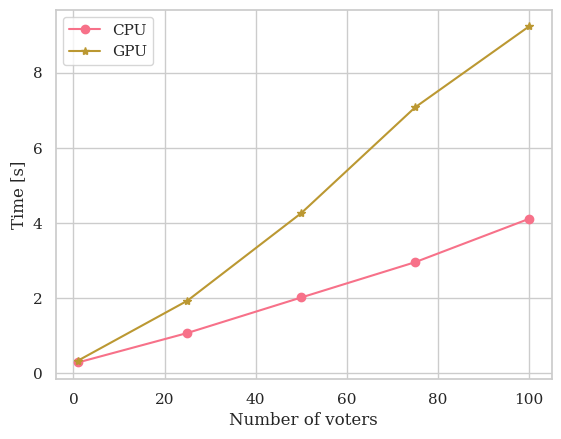

In [13]:
fig, ax = plt.subplots(1, 1,)
ax.plot(cca_df["n_voters"], cca_df["CPU_time"], label="CPU", marker='o')
ax.plot(cca_df["n_voters"], cca_df["GPU_time"], label="GPU", marker='*')
ax.set_xlabel("Number of voters")
ax.set_ylabel("Time [s]")
ax.legend()